In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def data_processing():
    Onion = pd.read_csv('E:\\MBA\\Job Search\\Datasets\\KVM_Data\\Onion.csv')
    Onion_Market = Onion.groupby('Market')[['Arrivals']].sum()
    Onion_list = Onion_Market.sort_values('Arrivals',ascending=False).head(10)
    Onion_list = Onion_list.index.to_list()
    onion_mkt_list = Onion['Market'].unique()
    d={}
    u_mkts = {}
    Onion['Date'] = pd.to_datetime(Onion['Date'])
    for mkt in onion_mkt_list:
        d[mkt] = Onion[Onion['Market']==mkt]
    for mkt in d:
        u_mkts[mkt] = d[mkt].groupby('Date')['Modal'].mean().to_frame()
    blrOnion = d['BENGALURU'].groupby('Date')['Modal'].mean().to_frame()
    for mkt in u_mkts:
        u_mkts[mkt].rename(columns = {'Modal': mkt}, inplace=True)
    blrOnion_np = blrOnion.to_numpy()
    def new_df(df):
        newdf = pd.date_range(start='1/1/2010', end='12/12/2023',freq='D').to_frame()
        newdf = newdf.rename(columns={0: 'Date'})
        for mkt in u_mkts:
            newdf = pd.concat([newdf,u_mkts[mkt]], axis=1)
        newdf.set_index('Date', inplace=True)
        newdf = newdf.ffill().bfill()
        return newdf
    newdf = new_df(u_mkts)
    Onion_df = newdf[Onion_list]
    lstm = Onion_df['BENGALURU']
    return lstm

In [3]:
lstm = data_processing()

In [4]:
    def df_to_X_y(df, window_size = 10):
        df_as_np = lstm
        X = []
        y = []
        for i in range(len(df_as_np)-window_size):
            row = [[a] for a in df_as_np[i:i + window_size]]
            X.append(row)
            label = df_as_np[i+ window_size]
            y.append(label)
        return np.array(X), np.array(y)

In [5]:
def lstm_fn(lstm = lstm, win_size = 10):
    X1, y1 = df_to_X_y(lstm, window_size = win_size)
    X1 = X1.reshape(len(lstm) - win_size,win_size,1)
    y1 = y1.reshape(len(lstm) - win_size)
    dates = lstm.index[win_size:]
    date_train1, X_train1, y_train1 = dates[:4000], X1[:4000], y1[:4000]
    date_val1, X_val1, y_val1 = dates[4000:4400], X1[4000:4400], y1[4000:4400]
    date_test1, X_test1, y_test1 = dates[4400:4950], X1[4400:4950], y1[4400:4950]
    return date_train1, X_train1, y_train1, date_val1, X_val1, y_val1, date_test1, X_test1, y_test1

In [6]:
date_train1, X_train1, y_train1, date_val1, X_val1, y_val1, date_test1, X_test1, y_test1 = lstm_fn(win_size = 50)

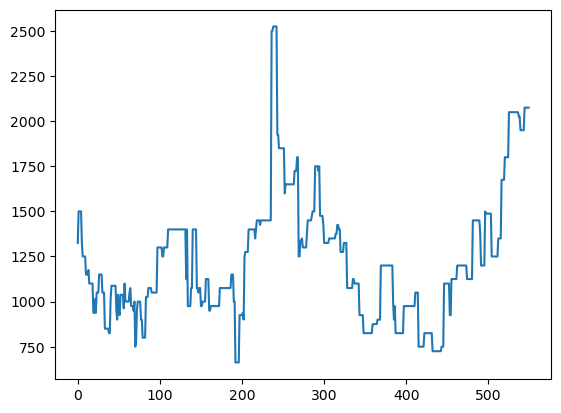

In [7]:
plt.plot(y_test1)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [9]:
def model_build():
    model = Sequential()
    model.add(LSTM(64))
    model.add(Dense(4, 'relu'))
    model.add(Dense(1, 'linear'))
    model.compile(loss = 'mse', optimizer = Adam (learning_rate = 0.001), metrics=['mean_absolute_error'])
    model.fit(X_train1, y_train1, epochs=200, batch_size=70, verbose=1)
    trainPredict = model.predict(X_train1).flatten()
    testPredict = model.predict(X_test1).flatten()
    valPredict = model.predict(X_val1).flatten()
    plt.figure(figsize=(10,6))
    plt.plot(date_val1,valPredict)
    plt.plot(date_val1,y_val1)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.xlabel('Date starting from 2020-12-25')
    plt.ylabel('Modal Price')
    plt.title('Validation Predictions vs Observations')
    plt.show()

    # Display the prediction graph on the test set
    plt.figure(figsize=(10,6))
    plt.plot(date_test1,testPredict)
    plt.plot(date_test1,y_test1)
    plt.legend(['Testing Predictions', 'Testing Observations'])
    plt.xlabel('Date starting from 2022-05-09')
    plt.ylabel('Modal Price')
    plt.title('Testing Predictions vs Observations')
    plt.show()
    return model

Epoch 1/200
58/58 [==============================] - 6s 22ms/step - loss: 3267820.5000 - mean_absolute_error: 1407.5918
Epoch 2/200
58/58 [==============================] - 1s 24ms/step - loss: 3260490.7500 - mean_absolute_error: 1404.9747
Epoch 3/200
58/58 [==============================] - 2s 25ms/step - loss: 3255023.7500 - mean_absolute_error: 1403.0336
Epoch 4/200
58/58 [==============================] - 2s 27ms/step - loss: 3249265.2500 - mean_absolute_error: 1400.9730
Epoch 5/200
58/58 [==============================] - 1s 23ms/step - loss: 3242620.5000 - mean_absolute_error: 1398.6189
Epoch 6/200
58/58 [==============================] - 1s 24ms/step - loss: 3235795.0000 - mean_absolute_error: 1396.1722
Epoch 7/200
58/58 [==============================] - 1s 25ms/step - loss: 3227596.0000 - mean_absolute_error: 1393.2101
Epoch 8/200
58/58 [==============================] - 2s 29ms/step - loss: 3218662.5000 - mean_absolute_error: 1390.0005
Epoch 9/200
58/58 [=====================

58/58 [==============================] - 2s 28ms/step - loss: 805901.0625 - mean_absolute_error: 327.8177
Epoch 137/200
58/58 [==============================] - 1s 23ms/step - loss: 796174.4375 - mean_absolute_error: 327.2920
Epoch 138/200
58/58 [==============================] - 1s 25ms/step - loss: 786624.0625 - mean_absolute_error: 323.9854
Epoch 139/200
58/58 [==============================] - 2s 31ms/step - loss: 776415.6875 - mean_absolute_error: 318.4810
Epoch 140/200
58/58 [==============================] - 1s 22ms/step - loss: 766973.6875 - mean_absolute_error: 315.9362
Epoch 141/200
58/58 [==============================] - 1s 23ms/step - loss: 756728.6250 - mean_absolute_error: 310.0385
Epoch 142/200
58/58 [==============================] - 1s 22ms/step - loss: 747134.5625 - mean_absolute_error: 306.1475
Epoch 143/200
58/58 [==============================] - 1s 21ms/step - loss: 737523.8125 - mean_absolute_error: 302.7204
Epoch 144/200
58/58 [==============================] -

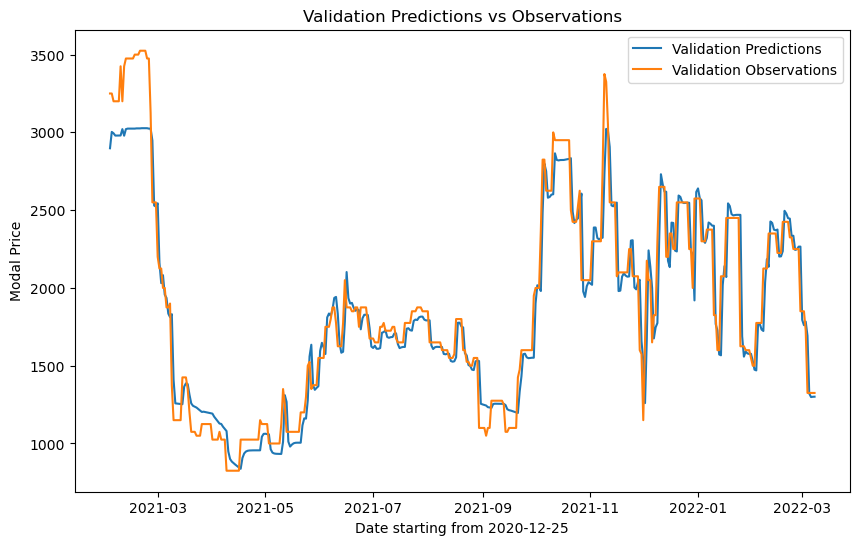

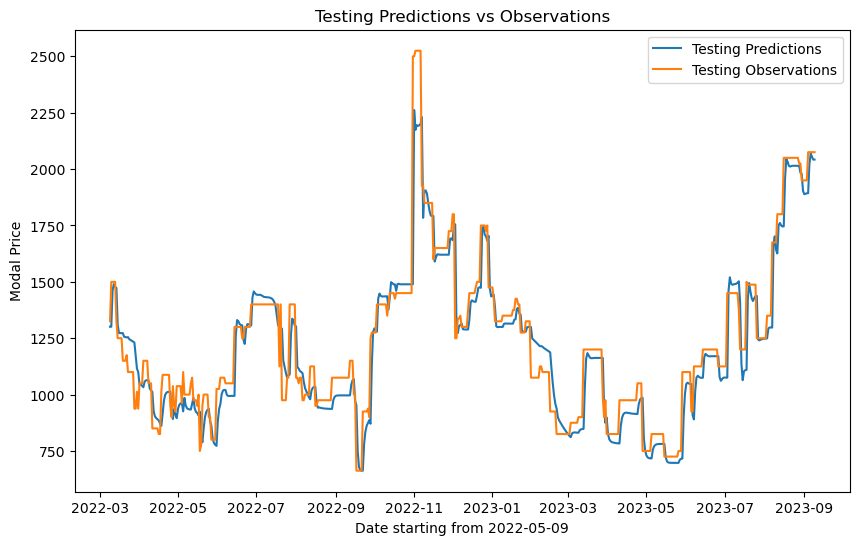

In [10]:
model = model_build()

In [23]:
def lstm_forecast(lstm=lstm):
    arr = 4600
    arr_end = arr +51
    temp_input = list(lstm[arr:arr_end])
    from numpy import array

    lst_output=[]
    n_steps=50
    i=0
    pred_days = 20
    while(i<pred_days):

        if(len(temp_input)>10):
            #print(temp_input)
            x_input=np.array(temp_input[1:])
#             print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = np.array(temp_input[0:]).reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1
            
    pred_dates = pd.date_range(start = lstm.index[arr_end], periods = pred_days+1, freq= '1d')
    pred_dates = pd.to_datetime(pred_dates[1:])
    plt.figure(figsize = (10,6))
    plt.plot(lstm.index[arr_end-200:arr_end] ,lstm[arr_end-200:arr_end])
    plt.plot(pred_dates ,lst_output)

0 day output [[873.87396]]
1 day output [[850.3624]]
2 day output [[826.1375]]
3 day output [[801.2615]]
4 day output [[776.27795]]
5 day output [[752.0127]]
6 day output [[729.1942]]
7 day output [[708.5653]]
8 day output [[691.3146]]
9 day output [[678.6582]]
10 day output [[670.70276]]
11 day output [[666.32477]]
12 day output [[664.12085]]
13 day output [[663.06573]]
14 day output [[662.5735]]
15 day output [[662.3463]]
16 day output [[662.24225]]
17 day output [[662.1946]]
18 day output [[662.173]]
19 day output [[662.1631]]


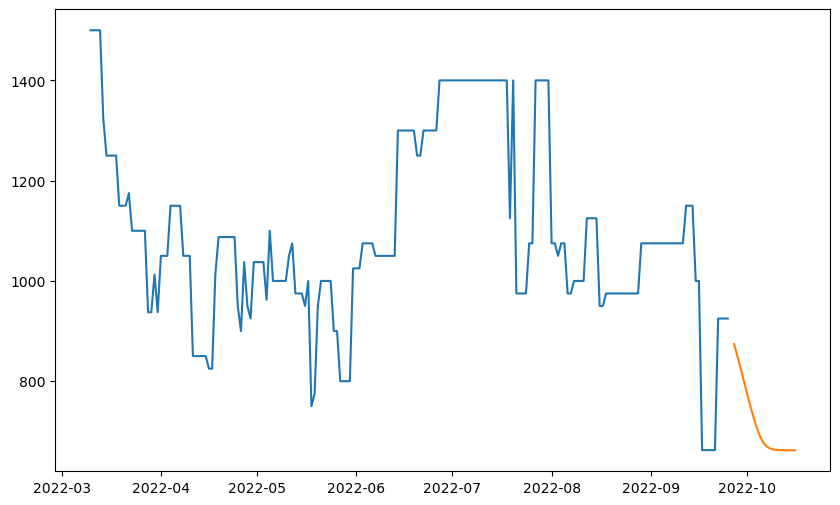

In [24]:
lstm_forecast(lstm)

In [18]:
lstm.index[4000]

Timestamp('2020-12-14 00:00:00')